# Fine-tuning the model unfreezing layers gradually

Found 3352 images belonging to 2 classes.
Found 837 images belonging to 2 classes.
Found 1198 images belonging to 2 classes.

=== STAGE 1: Unfreezing last 5 layers ===


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6498 - auc: 0.6945 - loss: 3.6114 - precision: 0.6498 - recall: 0.6498
Epoch 1: val_accuracy improved from -inf to 0.49880, saving model to saved_models/vgg19_finetune_20250405-094213/stage_1_best.weights.h5
104/104 ━━━━━━━━━━━━━━━━━━━━ 469s 4s/step - accuracy: 0.6504 - auc: 0.6952 - loss: 3.6087 - precision: 0.6504 - recall: 0.6504 - val_accuracy: 0.4988 - val_auc: 0.6896 - val_loss: 4.1190 - val_precision: 0.4988 - val_recall: 0.4988 - learning_rate: 1.0000e-04
Epoch 2/10
  1/104 ━━━━━━━━━━━━━━━━━━━━ 6:11 4s/step - accuracy: 0.6875 - auc: 0.7930 - loss: 3.0011 - precision: 0.6875 - recall: 0.6875

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.49880
104/104 ━━━━━━━━━━━━━━━━━━━━ 84s 783ms/step - accuracy: 0.6875 - auc: 0.7930 - loss: 3.0011 - precision: 0.6875 - recall: 0.6875 - val_accuracy: 0.4988 - val_auc: 0.6886 - val_loss: 4.2090 - val_precision: 0.4988 - val_recall: 0.4988 - learning_rate: 1.0000e-04
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8223 - auc: 0.8954 - loss: 2.7798 - precision: 0.8223 - recall: 0.8223
Epoch 3: val_accuracy improved from 0.49880 to 0.58654, saving model to saved_models/vgg19_finetune_20250405-094213/stage_1_best.weights.h5
104/104 ━━━━━━━━━━━━━━━━━━━━ 479s 5s/step - accuracy: 0.8224 - auc: 0.8955 - loss: 2.7792 - precision: 0.8224 - recall: 0.8224 - val_accuracy: 0.5865 - val_auc: 0.7407 - val_loss: 3.2156 - val_precision: 0.5865 - val_recall: 0.5865 - learning_rate: 1.0000e-04
Epoch 4/10
  1/104 ━━━━━━━━━━━━━━━━━━━━ 5:58 3s/step - accuracy: 0.7812 - auc: 0.8174 - loss: 2.9697 - precision: 0.7812 - recall: 0.7812
Epoch 4: val

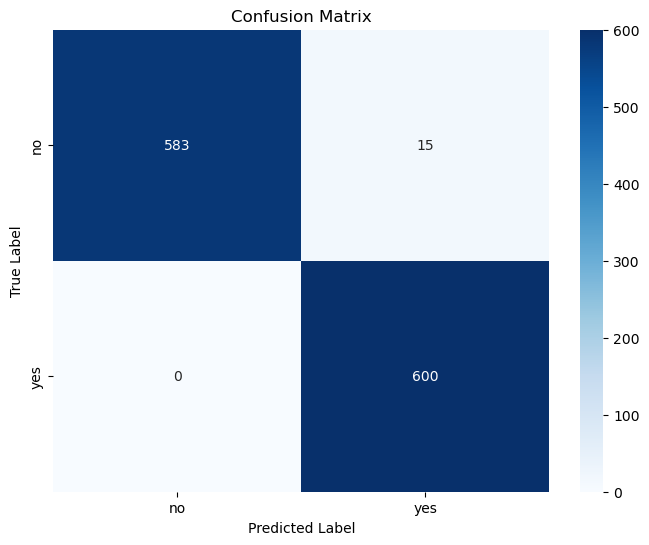


Training complete. Model weights saved to saved_models/vgg19_finetune_20250405-094213


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau,
    CSVLogger,
    TensorBoard
)
from tensorflow.keras.regularizers import l2
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

# ========== Configuration ==========
class Config:
    # Paths
    weights_path = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/model_weights/vgg19_model_01.weights.h5'
    train_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/tumorous_and_nontumorous/train'
    val_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/tumorous_and_nontumorous/val'
    test_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/tumorous_and_nontumorous/test'
    
    # Model parameters
    img_size = (224, 224)
    batch_size = 32
    num_classes = 2
    dense_units = [4608, 1152]  # Two dense layers as requested
    dropout_rate = 0.5
    l2_reg = 0.001  # L2 regularization factor
    
    # Training parameters
    initial_learning_rate = 1e-4
    fine_tune_learning_rate = 1e-5
    epochs_per_stage = 10  # Increased epochs for better convergence
    unfreeze_steps = [5, 10, 15, 20]  # More gradual unfreezing
    
    # Callback parameters
    early_stopping_patience = 5
    reduce_lr_patience = 3
    checkpoint_monitor = 'val_accuracy'
    
    # Output
    experiment_name = f"vgg19_finetune_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    logs_dir = os.path.join('logs', experiment_name)
    weights_dir = os.path.join('saved_models', experiment_name)

# Create output directories
os.makedirs(Config.logs_dir, exist_ok=True)
os.makedirs(Config.weights_dir, exist_ok=True)

# ========== Data Pipeline ==========
def create_data_generators():
    """Create enhanced data generators with professional augmentation"""
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,  # Increased rotation
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.2,  # Added shear
        zoom_range=0.2,  # Added zoom
        horizontal_flip=True,
        vertical_flip=True,  # Added vertical flip
        fill_mode='reflect',  # Better edge handling
        validation_split=0.2,
        brightness_range=[0.8, 1.2]  # Added brightness variation
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        Config.train_dir,
        target_size=Config.img_size,
        batch_size=Config.batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=42
    )

    val_generator = train_datagen.flow_from_directory(
        Config.train_dir,
        target_size=Config.img_size,
        batch_size=Config.batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_directory(
        Config.test_dir,
        target_size=Config.img_size,
        batch_size=Config.batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

# ========== Model Architecture ==========
def build_model():
    """Build enhanced VGG19 model with professional modifications"""
    # Load base model
    base_model = VGG19(
        weights=None,
        include_top=False,
        input_shape=(Config.img_size[0], Config.img_size[1], 3)
    )
    base_model.load_weights(Config.weights_path)
    
    # Enhanced classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # First dense layer with regularization
    x = Dense(
        Config.dense_units[0],
        activation='relu',
        kernel_regularizer=l2(Config.l2_reg),
        name='fc1')(x)
    x = BatchNormalization()(x)
    x = Dropout(Config.dropout_rate)(x)
    
    # Second dense layer
    x = Dense(
        Config.dense_units[1],
        activation='relu',
        kernel_regularizer=l2(Config.l2_reg),
        name='fc2')(x)
    x = BatchNormalization()(x)
    x = Dropout(Config.dropout_rate)(x)
    
    # Output layer
    predictions = Dense(
        Config.num_classes,
        activation='softmax',
        name='predictions')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

# ========== Training Utilities ==========
def get_callbacks(stage):
    """Create professional training callbacks"""
    callbacks = [
        ModelCheckpoint(
            filepath=os.path.join(Config.weights_dir, f'stage_{stage}_best.weights.h5'),  # Changed to .weights.h5
            monitor=Config.checkpoint_monitor,
            save_best_only=True,
            save_weights_only=True,
            mode='max',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=Config.reduce_lr_patience,
            min_lr=1e-7,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=Config.early_stopping_patience,
            restore_best_weights=True,
            verbose=1
        ),
        CSVLogger(
            os.path.join(Config.logs_dir, f'training_stage_{stage}.csv')
        ),
        TensorBoard(
            log_dir=os.path.join(Config.logs_dir, f'stage_{stage}'),
            histogram_freq=1
        )
    ]
    return callbacks

def incremental_unfreezing(model, base_model, unfreeze_layers, learning_rate):
    """Enhanced unfreezing with layer-wise learning rate multipliers"""
    # Freeze all layers first
    for layer in base_model.layers:
        layer.trainable = False
    
    # Unfreeze specified layers with progressive learning rate
    for i, layer in enumerate(base_model.layers[-unfreeze_layers:]):
        layer.trainable = True
        # Lower learning rate for earlier layers
        layer._name = f"{layer.name}_lr_{learning_rate/(2**(unfreeze_layers-i)):.1e}"
    
    # Recompile with new learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')]
    )
    return model

# ========== Evaluation ==========
def evaluate_model(model, test_generator):
    """Comprehensive model evaluation"""
    # Standard evaluation
    results = model.evaluate(test_generator)
    print(f"\nTest Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]*100:.2f}%")
    print(f"Test Precision: {results[2]*100:.2f}%")
    print(f"Test Recall: {results[3]*100:.2f}%")
    print(f"Test AUC: {results[4]*100:.2f}%")
    
    # Classification report
    test_preds = model.predict(test_generator)
    test_pred_classes = np.argmax(test_preds, axis=1)
    
    print("\nClassification Report:")
    print(classification_report(
        test_generator.classes,
        test_pred_classes,
        target_names=list(test_generator.class_indices.keys())))
    
    # Confusion matrix visualization
    cm = confusion_matrix(test_generator.classes, test_pred_classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(Config.logs_dir, 'confusion_matrix.png'))
    plt.show()

# ========== Main Training Loop ==========
def main():
    # Initialize
    train_gen, val_gen, test_gen = create_data_generators()
    model, base_model = build_model()
    
    # Training phases
    for stage, unfreeze_layers in enumerate(Config.unfreeze_steps):
        print(f"\n=== STAGE {stage+1}: Unfreezing last {unfreeze_layers} layers ===")
        
        # Determine learning rate
        current_lr = (Config.fine_tune_learning_rate if stage > 0 
                     else Config.initial_learning_rate)
        
        # Unfreeze and compile
        model = incremental_unfreezing(
            model, base_model, unfreeze_layers, current_lr)
        
        # Train
        history = model.fit(
            train_gen,
            steps_per_epoch=train_gen.samples // Config.batch_size,
            validation_data=val_gen,
            validation_steps=val_gen.samples // Config.batch_size,
            epochs=Config.epochs_per_stage,
            callbacks=get_callbacks(stage+1),
            verbose=1
        )
    
    # Final evaluation
    print("\n=== FINAL EVALUATION ===")
    evaluate_model(model, test_gen)
    
    # Save final model
    model.save_weights(os.path.join(Config.weights_dir, 'final_weights_model.weights.h5'))  # Changed to .weights.h5
    print(f"\nTraining complete. Model weights saved to {Config.weights_dir}")

if __name__ == "__main__":
    main()

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4608)           │     2,363,904 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 27,700,162 (105.67 MB)

 Trainable params: 25,374,594 (96.80 MB)

 Non-trainable params: 2,325,568 (8.87 MB)

# Unfreezing the entire network 


=== FULL NETWORK UNFREEZING PROCEDURE ===
Loading initial model from: /Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/saved_models/vgg19_finetune_20250405-094213/final_weights_model.weights.h5
Found 3352 images belonging to 2 classes.
Found 837 images belonging to 2 classes.
Found 1198 images belonging to 2 classes.

Starting full network training...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9820 - auc: 0.9963 - loss: 0.6802 - pr_auc: 0.9955 - precision: 0.9820 - recall: 0.9820 
Epoch 1: val_auc improved from -inf to 0.99827, saving model to /Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/saved_models/vgg19_finetune_20250405-091124/best_full_unfreeze.weights.h5
104/104 ━━━━━━━━━━━━━━━━━━━━ 1142s 11s/step - accuracy: 0.9820 - auc: 0.9963 - loss: 0.6802 - pr_auc: 0.9955 - precision: 0.9820 - recall: 0.9820 - val_accuracy: 0.9880 - val_auc: 0.9983 - val_loss: 0.6463 - val_pr_auc: 0.9979 - val_precision: 0.9880 - val_recall: 0.9880 - learning_rate: 1.0000e-05
Epoch 2/20
  1/104 ━━━━━━━━━━━━━━━━━━━━ 19:25 11s/step - accuracy: 0.9375 - auc: 0.9883 - loss: 0.7552 - pr_auc: 0.9888 - precision: 0.9375 - recall: 0.9375

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_auc improved from 0.99827 to 0.99963, saving model to /Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/saved_models/vgg19_finetune_20250405-091124/best_full_unfreeze.weights.h5
104/104 ━━━━━━━━━━━━━━━━━━━━ 93s 795ms/step - accuracy: 0.9375 - auc: 0.9883 - loss: 0.7552 - pr_auc: 0.9888 - precision: 0.9375 - recall: 0.9375 - val_accuracy: 0.9928 - val_auc: 0.9996 - val_loss: 0.6353 - val_pr_auc: 0.9996 - val_precision: 0.9928 - val_recall: 0.9928 - learning_rate: 1.0000e-05
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9722 - auc: 0.9916 - loss: 0.7020 - pr_auc: 0.9895 - precision: 0.9722 - recall: 0.9722 
Epoch 3: val_auc did not improve from 0.99963
104/104 ━━━━━━━━━━━━━━━━━━━━ 1157s 11s/step - accuracy: 0.9723 - auc: 0.9916 - loss: 0.7018 - pr_auc: 0.9895 - precision: 0.9723 - recall: 0.9723 - val_accuracy: 0.9868 - val_auc: 0.9995 - val_loss: 0.6297 - val_pr_auc: 0.9995 - val_precision: 0.9868 - val_recall: 0.9868 - learning_rate: 1.0000e-

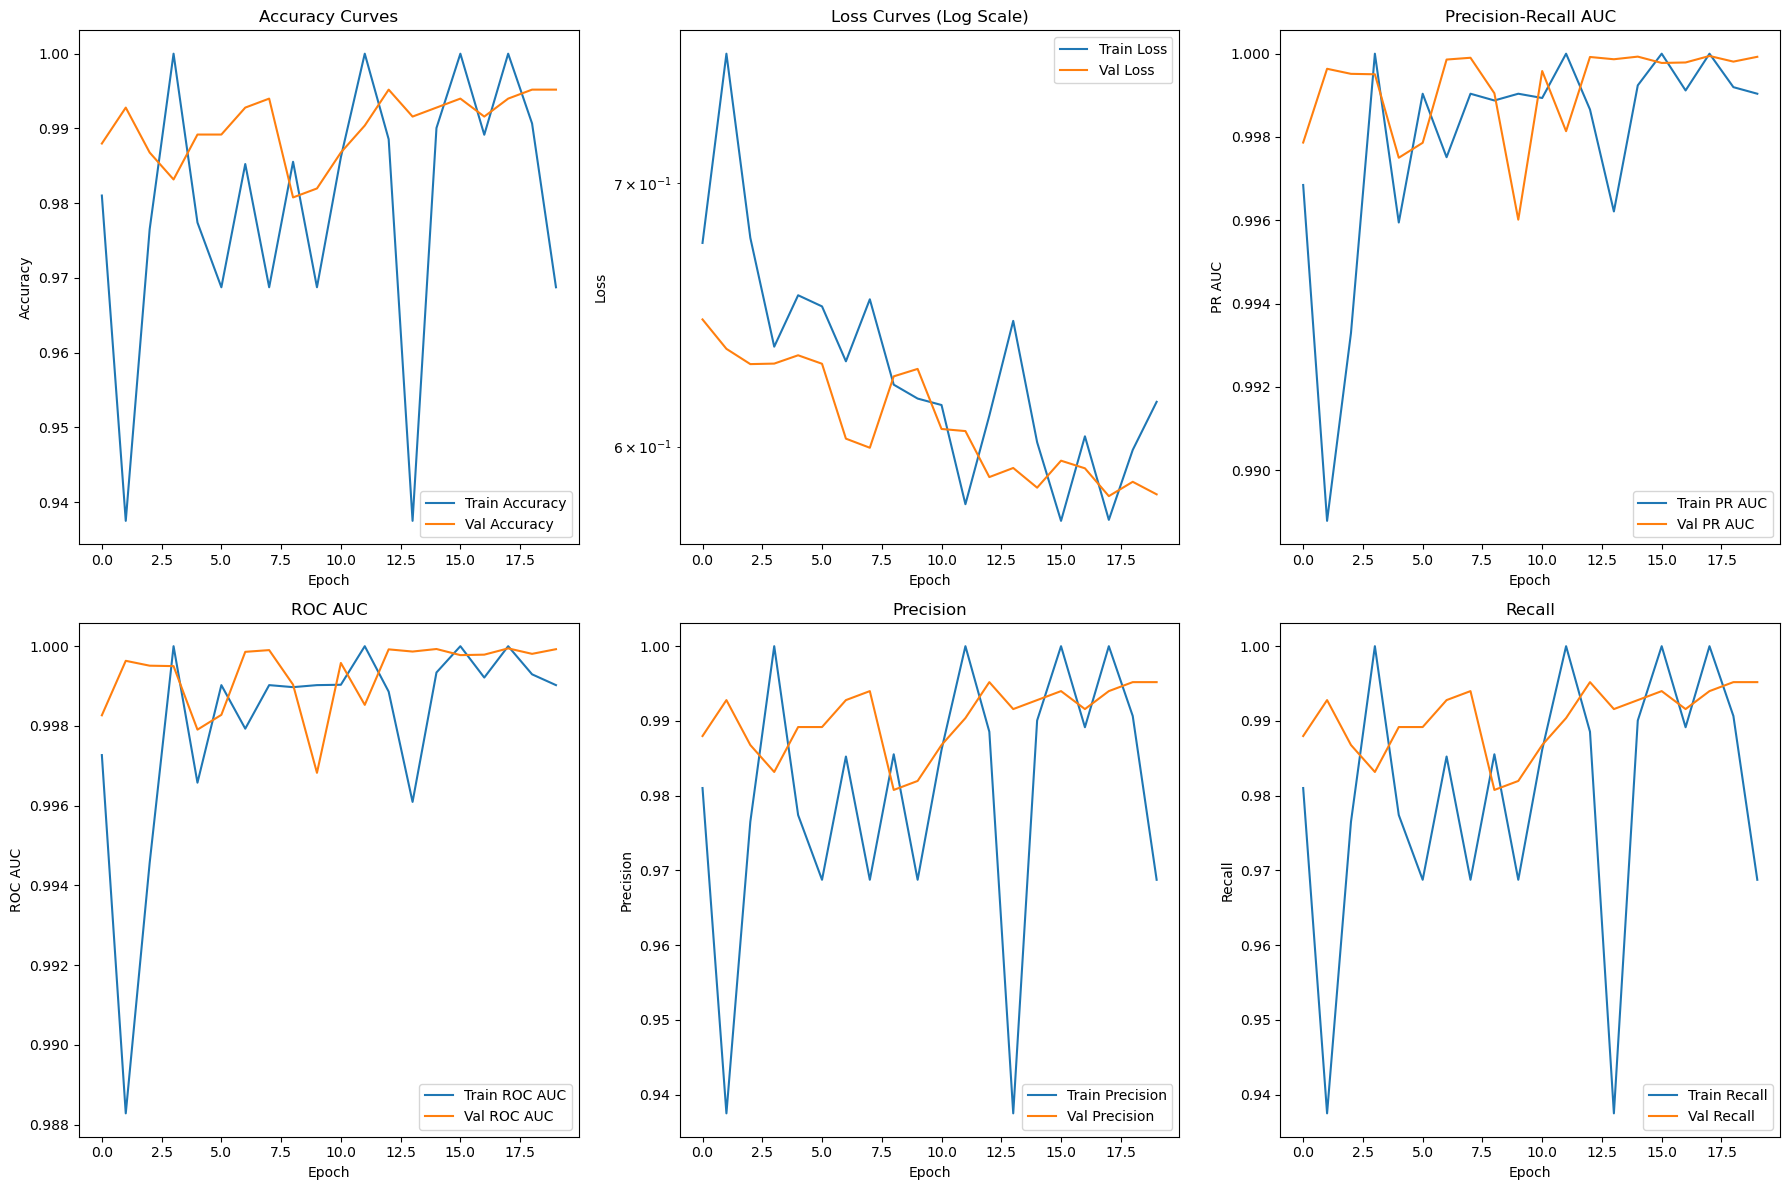

Training metrics plot saved to /Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/saved_models/vgg19_finetune_20250405-091124/full_unfreeze_metrics.png

=== FINAL EVALUATION ===
38/38 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.9958 - auc: 0.9975 - loss: 0.5940 - pr_auc: 0.9968 - precision: 0.9958 - recall: 0.9958

Test Loss: 0.5906
Test Accuracy: 99.58%
Test Precision: 99.58%
Test Recall: 99.58%
Test ROC AUC: 99.82%
Test PR AUC: 99.77%

Final unfrozen model saved to: /Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/saved_models/vgg19_finetune_20250405-091124/final_unfrozen_model.weights.h5


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau,
    CSVLogger,
    TensorBoard
)
from tensorflow.keras.regularizers import l2
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

# ========== Configuration ==========
class FullUnfreezeConfig:
    # Paths (using your specified locations)
    initial_model_path = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/saved_models/vgg19_finetune_20250405-094213/final_weights_model.weights.h5'
    output_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/saved_models/vgg19_finetune_20250405-091124'
    
    # Data paths
    train_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/tumorous_and_nontumorous/train'
    val_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/tumorous_and_nontumorous/val'
    test_dir = '/Volumes/KODAK/folder 02/Advance_Brain_Tumor_Classification/data/tumorous_and_nontumorous/test'
    
    # Model parameters
    img_size = (224, 224)
    batch_size = 32
    num_classes = 2
    
    # Training parameters
    initial_learning_rate = 1e-5  # Lower than initial fine-tuning
    min_learning_rate = 1e-7
    epochs = 20  # May need more epochs for full unfreezing
    
    # Callback parameters
    early_stopping_patience = 7  # More patience for full unfreezing
    reduce_lr_patience = 3
    checkpoint_monitor = 'val_auc'  # Monitoring AUC now
    
    # Regularization
    dropout_rate = 0.5
    l2_reg = 0.0005  # Slightly reduced L2

# Create output directories
os.makedirs(FullUnfreezeConfig.output_dir, exist_ok=True)
logs_dir = os.path.join(FullUnfreezeConfig.output_dir, 'logs')
os.makedirs(logs_dir, exist_ok=True)

# ========== Data Pipeline ==========
def create_data_generators():
    """Create data generators with professional augmentation"""
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect',
        brightness_range=[0.9, 1.1],
        validation_split=0.2
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        FullUnfreezeConfig.train_dir,
        target_size=FullUnfreezeConfig.img_size,
        batch_size=FullUnfreezeConfig.batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=42
    )

    val_generator = train_datagen.flow_from_directory(
        FullUnfreezeConfig.train_dir,
        target_size=FullUnfreezeConfig.img_size,
        batch_size=FullUnfreezeConfig.batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_directory(
        FullUnfreezeConfig.test_dir,
        target_size=FullUnfreezeConfig.img_size,
        batch_size=FullUnfreezeConfig.batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

# ========== Model Architecture ==========
def build_full_unfreeze_model():
    """Load and prepare model for full unfreezing"""
    # Load base architecture
    base_model = VGG19(
        weights=None,
        include_top=False,
        input_shape=(*FullUnfreezeConfig.img_size, 3)
    )
    
    # Reconstruct the model architecture
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(4608, activation='relu', kernel_regularizer=l2(FullUnfreezeConfig.l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(FullUnfreezeConfig.dropout_rate)(x)
    x = Dense(1152, activation='relu', kernel_regularizer=l2(FullUnfreezeConfig.l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(FullUnfreezeConfig.dropout_rate)(x)
    predictions = Dense(FullUnfreezeConfig.num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Load the fine-tuned weights
    model.load_weights(FullUnfreezeConfig.initial_model_path)
    
    return model, base_model

# ========== Training Utilities ==========
def get_full_unfreeze_callbacks():
    """Professional callbacks for full unfreezing"""
    callbacks = [
        ModelCheckpoint(
            filepath=os.path.join(FullUnfreezeConfig.output_dir, 'best_full_unfreeze.weights.h5'),
            monitor=FullUnfreezeConfig.checkpoint_monitor,
            save_best_only=True,
            save_weights_only=True,
            mode='max',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=FullUnfreezeConfig.reduce_lr_patience,
            min_lr=FullUnfreezeConfig.min_learning_rate,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=FullUnfreezeConfig.early_stopping_patience,
            restore_best_weights=True,
            verbose=1
        ),
        CSVLogger(os.path.join(logs_dir, 'full_unfreeze_training.csv')),
        TensorBoard(
            log_dir=os.path.join(logs_dir, 'full_unfreeze'),
            histogram_freq=1,
            profile_batch=0  # Disable profiling for cleaner logs
        )
    ]
    return callbacks

def prepare_full_unfreeze(model, base_model):
    """Unfreeze all layers with careful learning rate setup"""
    # Unfreeze all layers
    for layer in base_model.layers:
        layer.trainable = True
    
    # Apply layer-wise learning rate decay
    for i, layer in enumerate(base_model.layers):
        # Gradually reduce LR for earlier layers
        layer._name = f"{layer.name}_lr_decay_{i}"
    
    # Compile with careful optimizer settings
    model.compile(
        optimizer=Adam(
            learning_rate=FullUnfreezeConfig.initial_learning_rate,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07,
            amsgrad=False
        ),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc', multi_label=False),
            tf.keras.metrics.AUC(name='pr_auc', curve='PR')  # Precision-Recall AUC
        ]
    )
    return model

# ========== Visualization ==========
def plot_full_unfreeze_results(history):
    """Professional visualization of training metrics"""
    plt.figure(figsize=(18, 12))
    
    # Accuracy and Validation Accuracy
    plt.subplot(2, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curves')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Loss and Validation Loss (log scale)
    plt.subplot(2, 3, 2)
    plt.semilogy(history.history['loss'], label='Train Loss')
    plt.semilogy(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curves (Log Scale)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Precision-Recall AUC
    plt.subplot(2, 3, 3)
    plt.plot(history.history['pr_auc'], label='Train PR AUC')
    plt.plot(history.history['val_pr_auc'], label='Val PR AUC')
    plt.title('Precision-Recall AUC')
    plt.ylabel('PR AUC')
    plt.xlabel('Epoch')
    plt.legend()
    
    # ROC AUC
    plt.subplot(2, 3, 4)
    plt.plot(history.history['auc'], label='Train ROC AUC')
    plt.plot(history.history['val_auc'], label='Val ROC AUC')
    plt.title('ROC AUC')
    plt.ylabel('ROC AUC')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Precision
    plt.subplot(2, 3, 5)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Val Precision')
    plt.title('Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Recall
    plt.subplot(2, 3, 6)
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Val Recall')
    plt.title('Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plot_path = os.path.join(FullUnfreezeConfig.output_dir, 'full_unfreeze_metrics.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Training metrics plot saved to {plot_path}")

# ========== Main Execution ==========
def execute_full_unfreeze():
    print("\n=== FULL NETWORK UNFREEZING PROCEDURE ===")
    print(f"Loading initial model from: {FullUnfreezeConfig.initial_model_path}")
    
    # Prepare data and model
    train_gen, val_gen, test_gen = create_data_generators()
    model, base_model = build_full_unfreeze_model()
    
    # Prepare for full unfreezing
    model = prepare_full_unfreeze(model, base_model)
    callbacks = get_full_unfreeze_callbacks()
    
    # Training
    print("\nStarting full network training...")
    history = model.fit(
        train_gen,
        steps_per_epoch=train_gen.samples // FullUnfreezeConfig.batch_size,
        validation_data=val_gen,
        validation_steps=val_gen.samples // FullUnfreezeConfig.batch_size,
        epochs=FullUnfreezeConfig.epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # Visualization
    plot_full_unfreeze_results(history)
    
    # Final evaluation
    print("\n=== FINAL EVALUATION ===")
    results = model.evaluate(test_gen)
    print(f"\nTest Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]*100:.2f}%")
    print(f"Test Precision: {results[2]*100:.2f}%")
    print(f"Test Recall: {results[3]*100:.2f}%")
    print(f"Test ROC AUC: {results[4]*100:.2f}%")
    print(f"Test PR AUC: {results[5]*100:.2f}%")
    
    # Save final model
    final_path = os.path.join(FullUnfreezeConfig.output_dir, 'final_unfrozen_model.weights.h5')
    model.save_weights(final_path)
    print(f"\nFinal unfrozen model saved to: {final_path}")

if __name__ == "__main__":
    execute_full_unfreeze()